In [ ]:
import glob
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader

# Make objects with the images and masks. 
brain_scans = []
mask_files = glob.glob('kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

In [17]:
import res_define
import importlib

importlib.reload(res_define)
#this is if we changes stuff in the res_define, and we want to update it without restarting the py kernal

<module 'res_define' from '/home/sagie/Documents/BIU/יישומי סטטיסטיקה/Brain-MRI/res_define.py'>

In [2]:
train_df,test_df,val_df,train_ds,test_ds,val_ds,train_dl,test_dl,val_dl = res_define.create_data()

NameError: name 'res_define' is not defined

little data cloud:

In [3]:
import matplotlib.pyplot as plt

# number of images
num_train_images = len(train_df)
num_val_images = len(val_df)
num_test_images = len(test_df)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# distribution of diagnoses in training set
diagnosis_counts = train_df['tumour'].value_counts()
print("Diagnosis distribution in training set:")
print(diagnosis_counts)

# Plotting the distribution
plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar')
plt.title('Diagnosis Distribution in Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


NameError: name 'train_df' is not defined

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    num_samples = len(images)
    # Checking whether the function has been given the prediction array or not
    num_rows = 2 if type(predictions) == type(None) else 3
    
    # Defining figure
    fig, axes = plt.subplots(num_rows, num_samples,
                             figsize=(num_samples*5, num_samples+(num_rows*2)), dpi=200)
    
    for i in range(num_samples):
        # Plotting image
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')
        axes[0, i].set_title('Image', fontsize=20, fontweight='bold')
        axes[0, i].axis('off')
        
        # Plotting mask
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')
        axes[1, i].set_title('Mask', fontsize=20, fontweight='bold')
        axes[1, i].axis('off')
        
        # Plotting prediction
        if type(predictions) != type(None):
            axes[2, i].imshow(predictions[i], cmap='gray')
            axes[2, i].set_title(f'Prediction | IoU: {round(float(IoU_list[i]), 3)}',
                                 fontsize=19, fontweight='bold')
            axes[2, i].axis('off')
             
    # Adding title
    plt.suptitle('Images and Masks', fontsize=30, fontweight='bold')
    
    # Showing the figure
    plt.show()

plot_images_and_masks(train_df[train_df['tumour'] == 1]['image_path'].values[:6],
                      train_df[train_df['tumour'] == 0]['mask_path'].values[:6])

In [ ]:
import random

def show_random_images(df, num_images=5):
    plt.figure(figsize=(15, 5))
    random_images = df.sample(num_images)
    for i, row in enumerate(random_images.itertuples()):
        image = Image.open(row.image_path)
        mask = Image.open(row.mask_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.show()

show_random_images(train_df)

resNet model from torch!

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
# pre-trained ResNet model
device = res_define.device
resnet = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

resnet = resnet.to(device)

In [ ]:
print(resnet)

resNet training:

In [ ]:
res_define.train_model(resnet,train_dl,val_dl)

In [ ]:
resnet.eval()
res_define.test_model(resnet,test_dl)

grad cam of resnet:

For grad cam explaination 

https://github.com/jacobgil/pytorch-grad-cam

In [2]:
##HERE YOU WANT TRUE EXAMPLES, WHERE THE MODEL FAIL IT PROB WOULD LOOK BAD
res_define.visualize_prediction(resnet,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
res_define.visualize_prediction(resnet,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
res_define.visualize_prediction(resnet,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
res_define.visualize_prediction(resnet,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

NameError: name 'res_define' is not defined

ensamble learning of resNet and Efficient net:

efficient model:

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# device = res_define.device
device = 'cpu'
# Load pre-trained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
efficientnet.classifier[1] = nn.Sequential(
    nn.Linear(efficientnet.classifier[1].in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Move the model to the appropriate device
efficientnet = efficientnet.to(device)

# pre-trained ResNet model
resnet2 = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet2.fc = nn.Sequential(
    nn.Linear(resnet2.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

resnet2 = resnet2.to(device) # here you accedently put resnet2 = resnet.to with the old model

/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DE

In [11]:
# Instantiate the ensemble model
ensemble_model = res_define.EnsembleModel(resnet2, efficientnet)
ensemble_model = ensemble_model.to(device)

In [ ]:
# res_define.train_ensamble(ensemble_model,train_dl,val_dl)

In [12]:
# Saving the model
# torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

# Loading the model
ensemble_model.load_state_dict(torch.load('ensemble_model.pth'))

/tmp/ipykernel_31249/213547525.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ensemble_model.load_state_dict(torch.load('ensemble_model.pth'))


<All keys matched successfully>

In [8]:
res_define.test_model(ensemble_model,test_dl)

NameError: name 'test_dl' is not defined

grad cam for ensamble:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 1280x1)

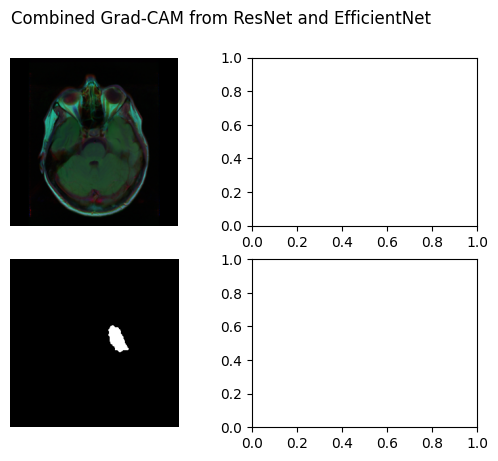

In [18]:

# Define the target layers for Grad-CAM
target_layers_resnet = [ensemble_model.modelA.layer4]  # Last convolutional layer in ResNet
target_layers_efficientnet = [ensemble_model.modelB.features[8]]  # Last convolutional layer in EfficientNet

visualize_ensemble_gradcam = lambda x : res_define.visualize_ensemble_gradcam(x,ensemble_model,target_layers_resnet,target_layers_efficientnet)

# Example usage
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

Now inftly more examples from train

In [ ]:
for _,row in test_df.iterrows():
    if row['tumour'] == 0:
        visualize_ensemble_gradcam(row['image_path'])